# ARIMA Model Case Study - Johnson & Johnson Time Series Forecasting 

            Sales
date             
1960-01-01   0.71
1960-04-01   0.63
1960-07-02   0.85
1960-10-01   0.44
1961-01-01   0.61
Data shape: (84, 1)


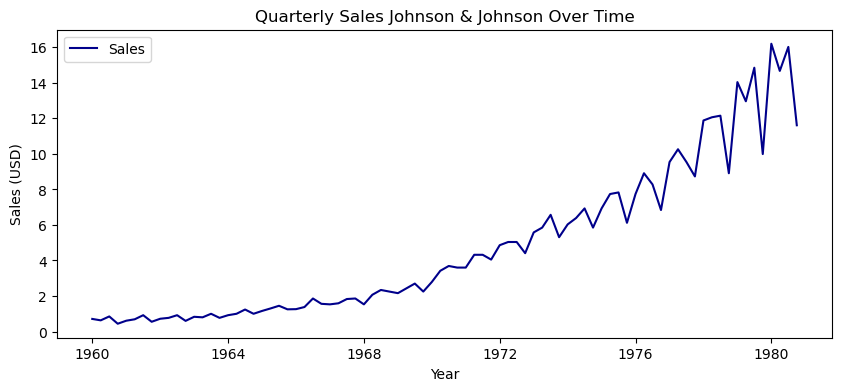

In [66]:
# Import Libraries and Load the Data
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error

warnings.filterwarnings('ignore')  # Ignore warnings for cleaner output

# Data Preparation
data = pd.read_csv('jj.csv', parse_dates=['date'])
data = data.set_index('date')
data = data.rename(columns={'data': 'Sales'})  # Renaming column
print(data.head())
print("Data shape:", data.shape)

# Visualize the Original Time Series
plt.figure(figsize=(10, 4))
plt.plot(data.index, data['Sales'], color='darkblue', label='Sales')
plt.title('Quarterly Sales Johnson & Johnson Over Time')
plt.xlabel('Year')
plt.ylabel('Sales (USD)')
plt.legend()
plt.show()

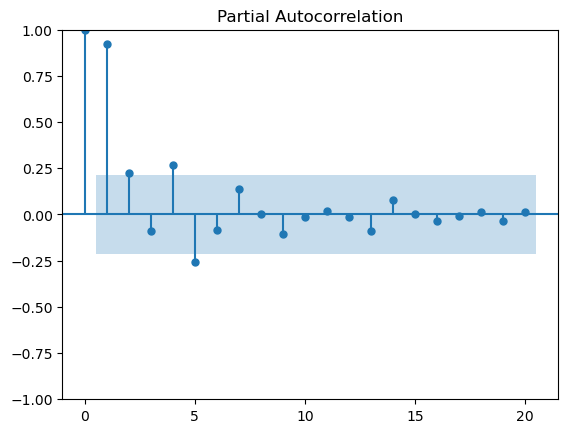

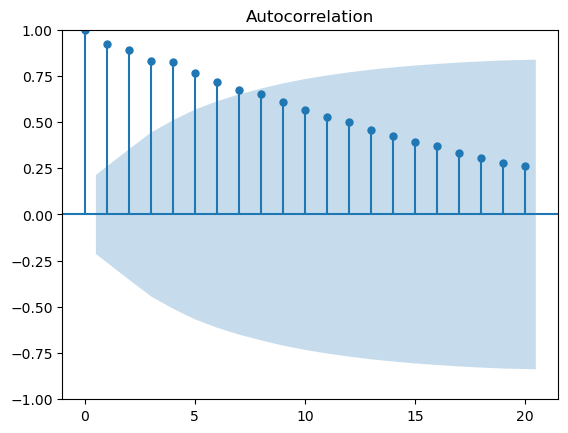

In [27]:
# plot the ACF and PACF to assess the correlations in the Sales (lags)
# see if it looks stationary
plot_pacf(data['Sales']);
plot_acf(data['Sales']);
plt.show()

# Stationarity Check (Augmented Dickey-Fuller Test)

In [28]:
# perform on the original data. 

ad_fuller_result = adfuller(data['Sales'])

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: 2.742016573457468
p-value: 1.0


In [29]:
# Here, Data is non-stationary (p>0.05),fail to reject the null hypothesis of a unit root.
# i.e,the time series is non-stationary 

In [30]:
# take the log()

data['data_log'] = np.log(data['Sales'])

# then take the first difference
data['data_tr_1'] = data['data_log'].diff()

data.head(10)

,Sales,data_log,data_tr_1
date,,,
1960-01-01,0.71,-0.342490,NaN
1960-04-01,0.63,-0.462035,-0.119545
1960-07-02,0.85,-0.162519,0.299517
1960-10-01,0.44,-0.820981,-0.658462
1961-01-01,0.61,-0.494296,0.326684
1961-04-02,0.69,-0.371064,0.123233
1961-07-02,0.92,-0.083382,0.287682
1961-10-01,0.55,-0.597837,-0.514455
1962-01-01,0.72,-0.328504,0.269333


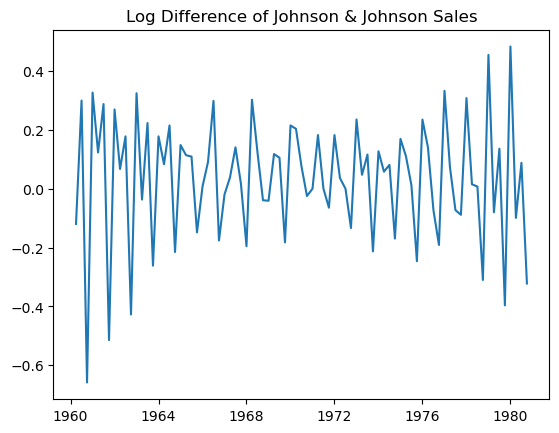

In [31]:
# plot

plt.plot(data['data_tr_1'])
plt.title("Log Difference of Johnson & Johnson Sales")
plt.show()

# Make the Series Stationary

In [32]:
# Log Transformation and Differencing
log_sales = np.log(data['Sales'])
log_diff_sales = log_sales.diff().dropna()
ad_fuller_result = adfuller(log_diff_sales)
print(f"ADF Statistic after 1st diff (log): {ad_fuller_result[0]:.3f}")
print(f"p-value: {ad_fuller_result[1]:.4f}")

ADF Statistic after 1st diff (log): -4.317
p-value: 0.0004


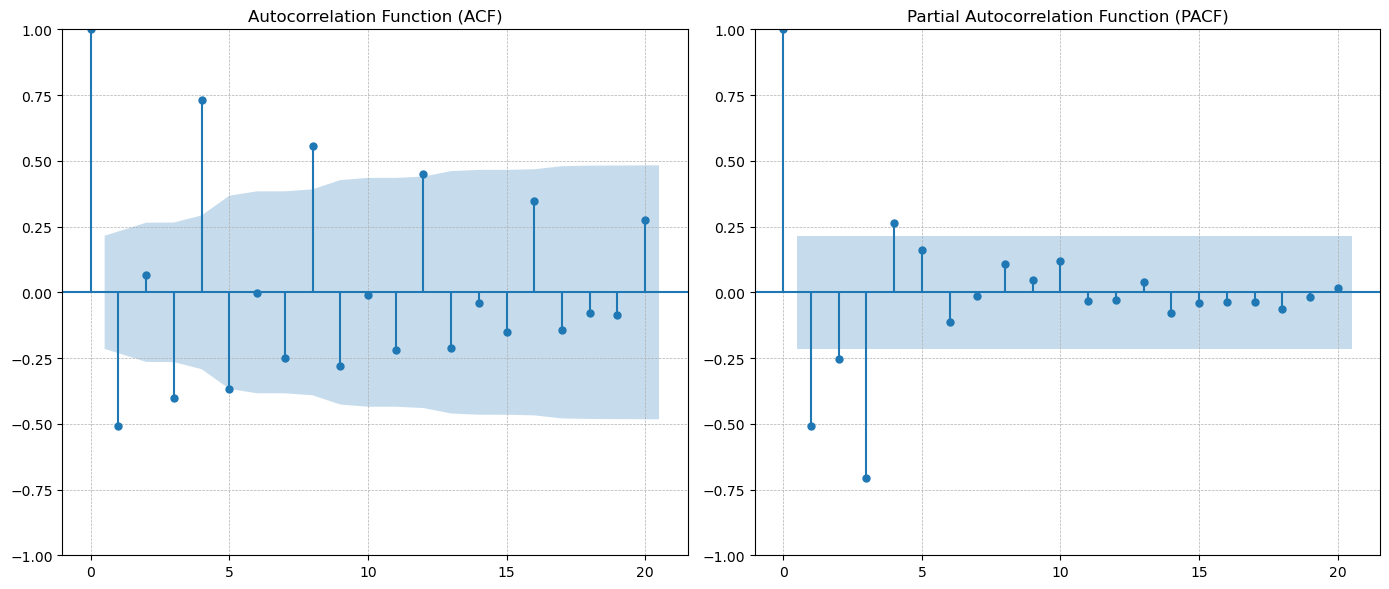

In [33]:
# Plot ACF and PACF with enhancements
plt.figure(figsize=(14, 6))  

# ACF plot
plt.subplot(121)
plot_acf(log_diff_sales, lags=20, ax=plt.gca(), title='Autocorrelation Function (ACF)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)  # Add grid lines for better readability

# PACF plot
plt.subplot(122)
plot_pacf(log_diff_sales, lags=20, ax=plt.gca(), title='Partial Autocorrelation Function (PACF)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()  
plt.show()

# ARIMA Model (p,d,q)

In [34]:
# Manual Search for the Best ARIMA(p,d,q) Model using AIC
# Find Best ARIMA Model (Loop over p=0-5,d=0-2,q=0-5)

import statsmodels.api as sm

def find_best_arima(data, p_range, d_range, q_range):
    """
    Function to determine the best ARIMA model based on AIC.
    
    Parameters:
    data (pd.Series): Time series data.
    p_range (int): Maximum number of AR (Auto-Regressive) terms to consider.
    d_range (int): Maximum number of differences allowed.
    q_range (int): Maximum number of MA (Moving Average) terms to consider.
    
    Returns:
    tuple: Best ARIMA model order and the corresponding AIC.
    """
    best_aic = float('inf')
    best_order = None
    best_model = None

    for p in range(p_range):
        for d in range(d_range):
            for q in range(q_range):
                try:
                    model = sm.tsa.arima.ARIMA(data, order=(p, d, q))
                    results = model.fit()
                    if results.aic < best_aic:
                        best_aic = results.aic
                        best_order = (p, d, q)
                        best_model = results
                except Exception as e:
                    print(f"Failed to fit ARIMA({p},{d},{q}): {str(e)}")
                    continue

    print(f"Best ARIMA order by AIC: {best_order}, AIC = {best_aic:.3f}")
    return best_order, best_aic, best_model


best_order, best_aic, best_model = find_best_arima(log_sales, 5, 2, 5)  


Best ARIMA order by AIC: (4, 1, 3), AIC = -144.198


In [35]:
# Fit the chosen ARIMA model
model = sm.tsa.arima.ARIMA(log_sales, order=(4, 1, 3))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   84
Model:                 ARIMA(4, 1, 3)   Log Likelihood                  80.099
Date:                Thu, 10 Apr 2025   AIC                           -144.198
Time:                        20:28:46   BIC                           -124.847
Sample:                             0   HQIC                          -136.423
                                 - 84                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0005      0.060     -0.009      0.993      -0.118       0.116
ar.L2          0.0137      0.049      0.279      0.780      -0.083       0.110
ar.L3          0.0272      0.048      0.565      0.5

In [36]:
# In-Sample Metrics
predictions = fitted_model.get_prediction(start=log_sales.index[0], dynamic=False)
predicted_values = np.exp(predictions.predicted_mean)
actual_values = data.loc[predictions.predicted_mean.index, 'Sales']

mae = mean_absolute_error(actual_values, predicted_values)
mse = mean_squared_error(actual_values, predicted_values)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((actual_values - predicted_values) / actual_values)) * 100
print("\nIn-Sample Evaluation Metrics:")
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")


In-Sample Evaluation Metrics:
MAE: 0.28
MSE: 0.16
RMSE: 0.40
MAPE: 8.21%


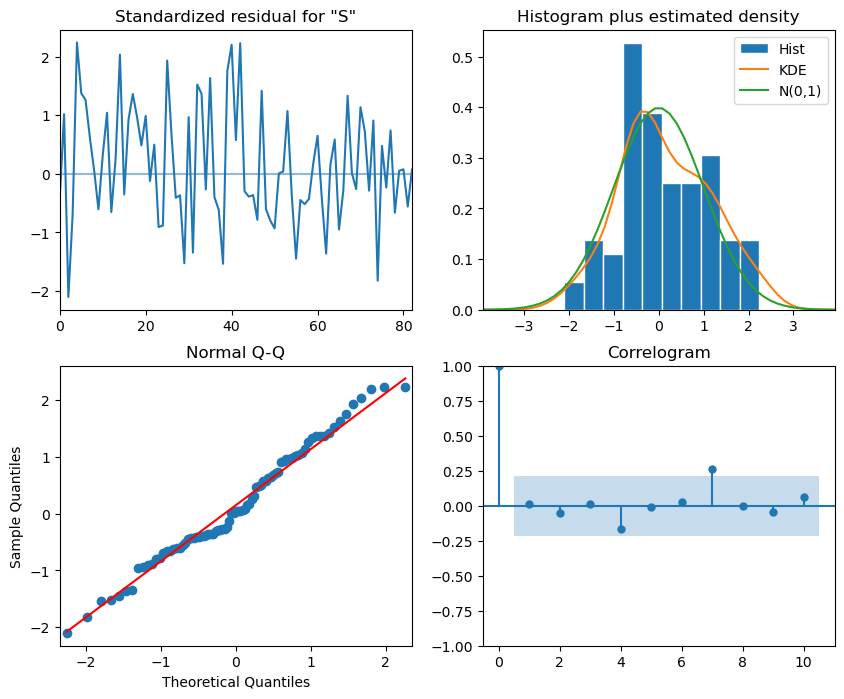

In [37]:
# Residual Diagnostics
fitted_model.plot_diagnostics(figsize=(10, 8))
plt.show()

# Forecast the Next 24 Months (8 Quarters)

In [39]:
def forecast_arima(model_fit, steps, start_date):
    """
    Forecasts future values using an ARIMA model fit.
    
    Parameters:
    model_fit (ARIMAResults): The fitted ARIMA model.
    steps (int): Number of future steps to forecast.
    start_date (str): The starting date of the forecast period (YYYY-MM-DD).
    
    Returns:
    tuple: A tuple containing the forecast series, lower and upper confidence intervals.
    """
    # Get forecast result
    forecast_result = model_fit.get_forecast(steps=steps)
    log_forecast = forecast_result.predicted_mean
    log_conf_int = forecast_result.conf_int()
    
    # Convert forecasts back to original scale
    forecast = np.exp(log_forecast)
    conf_int_lower = np.exp(log_conf_int.iloc[:, 0])
    conf_int_upper = np.exp(log_conf_int.iloc[:, 1])
    
    # Set index for the forecast period
    forecast.index = pd.date_range(start=start_date, periods=steps, freq='Q')
    conf_int_lower.index = forecast.index
    conf_int_upper.index = forecast.index
    
    return forecast, conf_int_lower, conf_int_upper

n_steps = 8  # Forecast 8 quarters ahead
start_date = '1981-01-01'  # Starting date of the forecast period
forecast, conf_int_lower, conf_int_upper = forecast_arima(model_fit, n_steps, start_date)

# Display the forecast and confidence intervals
print("Forecast:")
print(forecast)
print("\nConfidence Interval Lower Bound:")
print(conf_int_lower)
print("\nConfidence Interval Upper Bound:")
print(conf_int_upper)


Forecast:
1981-03-31    18.040641
1981-06-30    16.652442
1981-09-30    18.003913
1981-12-31    13.452457
1982-03-31    20.327859
1982-06-30    18.816207
1982-09-30    20.201683
1982-12-31    15.522581
Freq: Q-DEC, Name: predicted_mean, dtype: float64

Confidence Interval Lower Bound:
1981-03-31    15.183629
1981-06-30    13.882934
1981-09-30    14.763898
1981-12-31    11.005079
1982-03-31    15.417940
1982-06-30    14.100820
1982-09-30    14.869924
1982-12-31    11.357666
Freq: Q-DEC, Name: lower Sales, dtype: float64

Confidence Interval Upper Bound:
1981-03-31    21.435241
1981-06-30    19.974439
1981-09-30    21.954965
1981-12-31    16.444097
1982-03-31    26.801366
1982-06-30    25.108444
1982-09-30    27.445196
1982-12-31    21.214790
Freq: Q-DEC, Name: upper Sales, dtype: float64


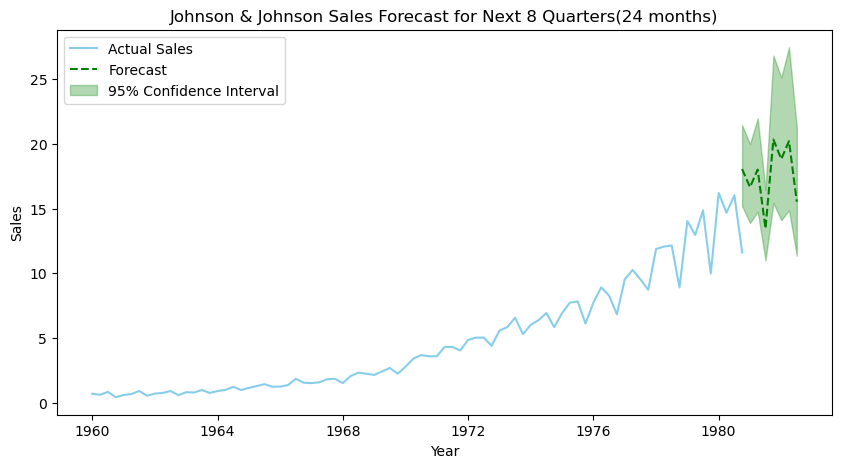

In [40]:
# Plot the Forecast vs Original Series

# Prepare index for forecast periods
forecast_index = pd.date_range(start='1980-08-01', periods=8, freq='Q')
# Plot the original series and forecast
plt.figure(figsize=(10,5))
plt.plot(data.index, data['Sales'], color='skyblue',label='Actual Sales')
plt.plot(forecast_index, forecast.values, label='Forecast', color='green', linestyle='--')
# Plot confidence interval as shaded area
plt.fill_between(forecast_index, conf_int_lower.values, conf_int_upper.values, 
                 color='green', alpha=0.3, label='95% Confidence Interval')
plt.title('Johnson & Johnson Sales Forecast for Next 8 Quarters(24 months)')
plt.xlabel('Year')
plt.ylabel('Sales')
plt.legend(loc='upper left')
plt.show()


# LSTM and GRU Model Case Study - Johnson & Johnson  Time Series Forecasting

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


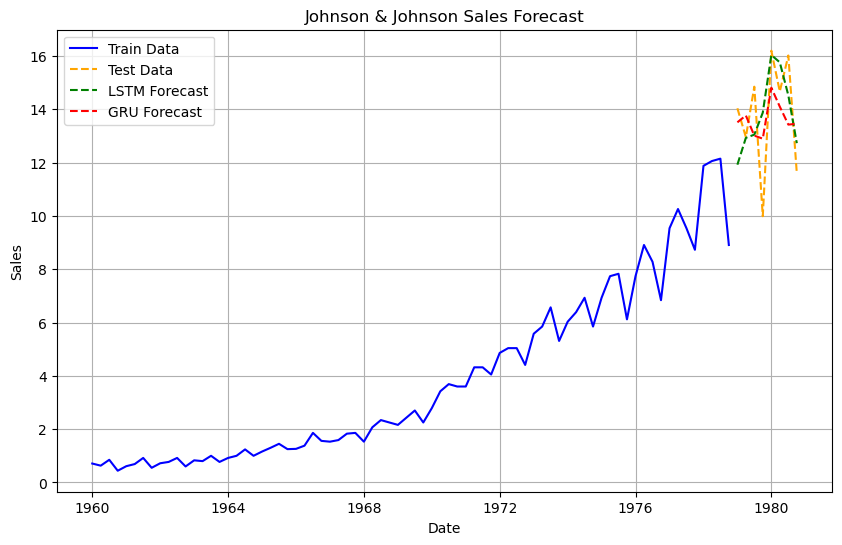

LSTM Model Metrics:
 MAE: 1.46, MSE: 3.44, RMSE: 1.86, MAPE: 11.72%
GRU Model Metrics:
 MAE: 1.56, MSE: 3.15, RMSE: 1.77, MAPE: 12.01%


In [50]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv('jj.csv', parse_dates=['date'])
df.set_index('date', inplace=True)  # Set date column as index for time series analysis
data = df['data']  # Extract sales data

# Define train/test split 
train_size = 76  # Set number of points in the training set (1960-1978)
train = data.iloc[:train_size]
test = data.iloc[train_size:]

# Log transformation to stabilize variance
train_log = np.log(train.values)  

# First differencing to remove trend and make the series stationary
train_log_diff = np.diff(train_log)

# Prepare data for LSTM/GRU models
n_steps = 8  # Number of lag observations to use for predicting the next value
X_train, y_train = [], []

# Create input-output pairs for training
for i in range(n_steps, len(train_log_diff)):
    X_train.append(train_log_diff[i-n_steps:i])
    y_train.append(train_log_diff[i])

X_train, y_train = np.array(X_train), np.array(y_train)

# Normalize features to aid in model convergence
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape(-1, 1)).reshape(X_train.shape)
y_train_scaled = scaler.transform(y_train.reshape(-1, 1)).flatten()

# Reshape X_train for LSTM/GRU input: [samples, time steps, features]
X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], n_steps, 1))

# LSTM model definition
model_lstm = Sequential([
    LSTM(50, activation='tanh', input_shape=(n_steps, 1)), 
    Dense(1)
])
model_lstm.compile(optimizer='adam', loss='mse')

# Train LSTM model
model_lstm.fit(X_train_scaled, y_train_scaled, epochs=100, batch_size=16, verbose=0)

# GRU model definition
model_gru = Sequential([
    GRU(50, activation='tanh', input_shape=(n_steps, 1)), 
    Dense(1)
])
model_gru.compile(optimizer='adam', loss='mse')

# Train GRU model
model_gru.fit(X_train_scaled, y_train_scaled, epochs=100, batch_size=16, verbose=0)

# Forecasting setup
last_window = scaler.transform(train_log_diff[-n_steps:].reshape(-1, 1)).reshape(n_steps, 1)
last_log_value = train_log[-1]  # last known log value
forecast_lstm, forecast_gru = [], []

# Generate forecasts
for _ in range(len(test)):
    X_input = last_window.reshape(1, n_steps, 1)
    pred_diff_lstm = scaler.inverse_transform(model_lstm.predict(X_input))[0][0]
    pred_diff_gru = scaler.inverse_transform(model_gru.predict(X_input))[0][0]
    
    # Invert differencing
    new_log_value_lstm = last_log_value + pred_diff_lstm
    new_log_value_gru = last_log_value + pred_diff_gru
    forecast_lstm.append(np.exp(new_log_value_lstm))
    forecast_gru.append(np.exp(new_log_value_gru))
    
    # Update last log value and window
    last_log_value = new_log_value_lstm  # This should ideally be updated from actual data when available
    last_window = np.roll(last_window, -1)
    last_window[-1] = scaler.transform([[pred_diff_lstm]])

# Display forecast results
plt.figure(figsize=(10, 6))
plt.plot(train.index, train, label='Train Data', color='blue')
plt.plot(test.index, test, label='Test Data', color='orange', linestyle='--')
plt.plot(test.index, forecast_lstm, label='LSTM Forecast', color='green', linestyle='--')
plt.plot(test.index, forecast_gru, label='GRU Forecast', color='red', linestyle='--')
plt.title('Johnson & Johnson Sales Forecast')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

# Compute evaluation metrics
actual_test_values = test.values
mae_lstm = mean_absolute_error(actual_test_values, forecast_lstm)
mse_lstm = mean_squared_error(actual_test_values, forecast_lstm)
rmse_lstm = np.sqrt(mse_lstm)
mape_lstm = np.mean(np.abs((actual_test_values - forecast_lstm) / actual_test_values)) * 100

mae_gru = mean_absolute_error(actual_test_values, forecast_gru)
mse_gru = mean_squared_error(actual_test_values, forecast_gru)
rmse_gru = np.sqrt(mse_gru)
mape_gru = np.mean(np.abs((actual_test_values - forecast_gru) / actual_test_values)) * 100

print(f"LSTM Model Metrics:\n MAE: {mae_lstm:.2f}, MSE: {mse_lstm:.2f}, RMSE: {rmse_lstm:.2f}, MAPE: {mape_lstm:.2f}%")
print(f"GRU Model Metrics:\n MAE: {mae_gru:.2f}, MSE: {mse_gru:.2f}, RMSE: {rmse_gru:.2f}, MAPE: {mape_gru:.2f}%")


# ARIMA Time Series Modeling for Amazon Stock Price (Monthly)

                Close
Date                 
2018-02-20  73.417503
2018-02-21  74.146004
2018-02-22  74.266998
2018-02-23  75.000000
2018-02-26  76.097504
Number of monthly data points: 61


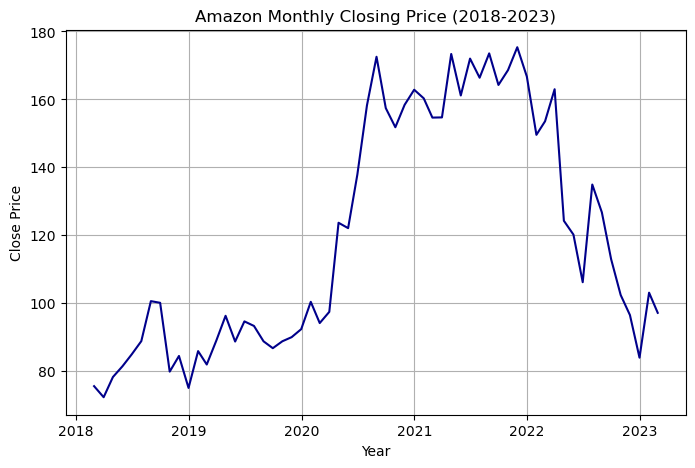

In [52]:
# Import Necessary Libraries
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Data Preparation
# Load the dataset
df = pd.read_csv('AMZN.csv', parse_dates=['Date'], index_col='Date')
# The first few rows
print(df[['Close']].head())
# Resample to monthly frequency, taking the last closing price of each month
monthly_close = df['Close'].resample('M').last()
print("Number of monthly data points:", len(monthly_close))

# Visualize the Monthly Closing Price Time Series
#Plot Amazon Monthly Closing Price
plt.figure(figsize=(8,5))
plt.plot(monthly_close.index, monthly_close.values, color='darkblue')
plt.title('Amazon Monthly Closing Price (2018-2023)')
plt.xlabel('Year')
plt.ylabel('Close Price')
plt.grid(True)
plt.show()


# Test for Stationarity with Augmented Dickey-Fuller (ADF) Test

In [53]:
result = adfuller(monthly_close.dropna())
print("ADF Statistic:", result[0])
print("p-value:", result[1])

ADF Statistic: -1.5392301342169907
p-value: 0.5140232647833247


In [ ]:
# p-value < 0.05
# The p-value ~ 0.51 is much greater than 0.05, 
# fail to reject the null hypothesis

In [ ]:
# Make the Series Stationary – Log Transform and Differencing

In [54]:
# Log Transformation
log_close = np.log(monthly_close)
result_log = adfuller(log_close.dropna())
print("ADF Statistic (log):", result_log[0])
print("p-value (log):", result_log[1])


ADF Statistic (log): -1.6666161408109945
p-value (log): 0.4483896872175652


In [55]:
#After log transformation, the p-value is ~0.45. 
#still p > 0.05, so the log series remains non-stationary.
#First Differencing (on Log-Transformed Data)
diff_log_close = log_close.diff().dropna()  # 1st difference of log series
result_diff_log = adfuller(diff_log_close)
print("ADF Statistic (log diff):", result_diff_log[0])
print("p-value (log diff):", result_diff_log[1])


ADF Statistic (log diff): -8.920696772064435
p-value (log diff): 1.0430561375247622e-14


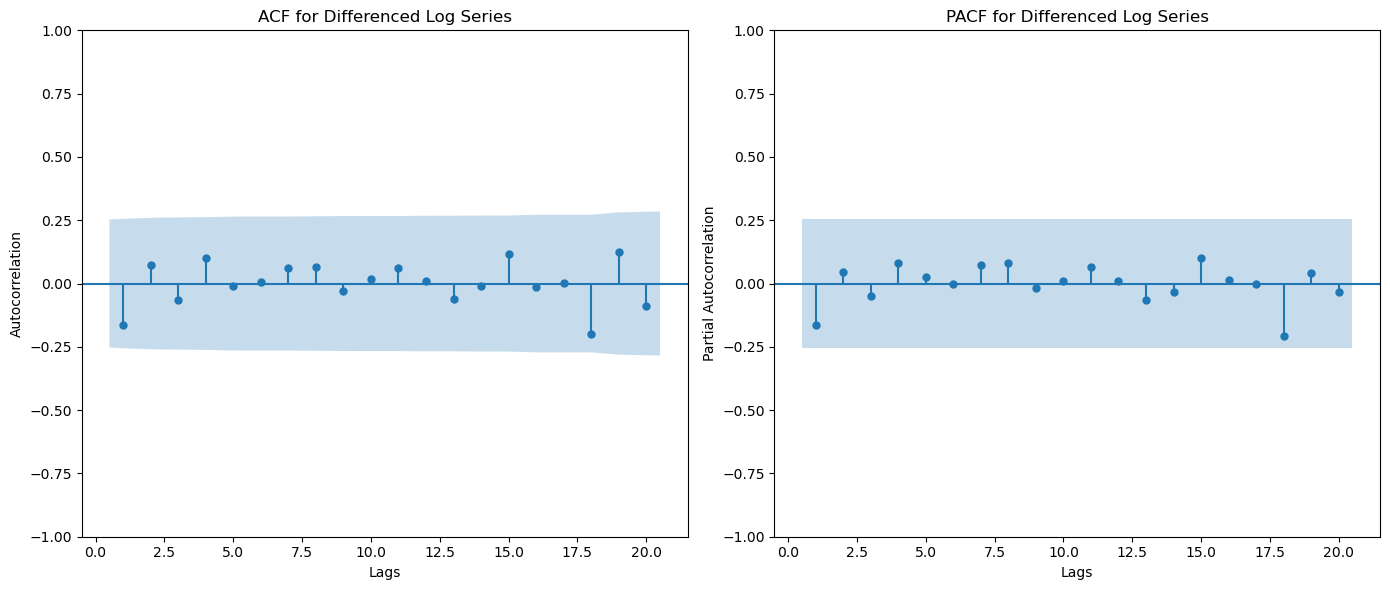

In [56]:
plt.figure(figsize=(14, 6))  # Adjusted figure size for better visibility

# Plotting ACF
plt.subplot(1, 2, 1)
plot_acf(diff_log_close, ax=plt.gca(), lags=20, zero=False, title='ACF for Differenced Log Series')
plt.xlabel('Lags')  # Adding x-axis label for clarity
plt.ylabel('Autocorrelation')  # Adding y-axis label for clarity

# Plotting PACF
plt.subplot(1, 2, 2)
plot_pacf(diff_log_close, ax=plt.gca(), lags=20, zero=False, title='PACF for Differenced Log Series')
plt.xlabel('Lags')  
plt.ylabel('Partial Autocorrelation')  
plt.tight_layout()
plt.show()


# ARMA Model Fit (p,d,q)

In [58]:
#Manual Grid Search for ARIMA(p,d,q) using AIC

def manual_grid_search_arima(data, max_p, max_q, d=1):
    """
    Perform a manual grid search to find the best ARIMA(p,d,q) model based on AIC.
    
    Parameters:
    data (pd.Series): The time series data on which to fit the ARIMA model.
    max_p (int): The maximum number of AR terms to consider.
    max_q (int): The maximum number of MA terms to consider.
    d (int): The order of differencing (default is 1).
    
    Returns:
    tuple: Best ARIMA model order and the corresponding AIC.
    """
    warnings.filterwarnings("ignore")  # Ignore convergence warnings for some models
    best_aic = np.inf
    best_order = None
    
    for p in range(max_p + 1):  # range starts at 0 and includes max_p
        for q in range(max_q + 1):  # range starts at 0 and includes max_q
            try:
                model = ARIMA(data, order=(p, d, q))
                res = model.fit()
                print(f"ARIMA({p},{d},{q}) AIC: {res.aic:.2f}")
                if res.aic < best_aic:
                    best_aic = res.aic
                    best_order = (p, d, q)
            except Exception as e:
                print(f"Failed to fit ARIMA({p},{d},{q}): {str(e)}")
                continue
    
    print(f"Best model by AIC: ARIMA{best_order} with AIC={best_aic:.2f}")
    return best_order, best_aic


best_order, best_aic = manual_grid_search_arima(log_close, max_p=8, max_q=8)


ARIMA(0,1,0) AIC: -107.97
ARIMA(0,1,1) AIC: -107.40
ARIMA(0,1,2) AIC: -105.61
ARIMA(0,1,3) AIC: -103.69
ARIMA(0,1,4) AIC: -102.42
ARIMA(0,1,5) AIC: -100.42
ARIMA(0,1,6) AIC: -98.44
ARIMA(0,1,7) AIC: -96.88
ARIMA(0,1,8) AIC: -95.09
ARIMA(1,1,0) AIC: -107.56
ARIMA(1,1,1) AIC: -105.99
ARIMA(1,1,2) AIC: -104.02
ARIMA(1,1,3) AIC: -102.07
ARIMA(1,1,4) AIC: -100.42
ARIMA(1,1,5) AIC: -98.42
ARIMA(1,1,6) AIC: -97.01
ARIMA(1,1,7) AIC: -95.25
ARIMA(1,1,8) AIC: -93.38
ARIMA(2,1,0) AIC: -105.73
ARIMA(2,1,1) AIC: -104.02
ARIMA(2,1,2) AIC: -102.08
ARIMA(2,1,3) AIC: -100.26
ARIMA(2,1,4) AIC: -98.83
ARIMA(2,1,5) AIC: -96.73
ARIMA(2,1,6) AIC: -97.36
ARIMA(2,1,7) AIC: -97.85
ARIMA(2,1,8) AIC: -91.28
ARIMA(3,1,0) AIC: -103.89
ARIMA(3,1,1) AIC: -102.08
ARIMA(3,1,2) AIC: -100.20
ARIMA(3,1,3) AIC: -98.68
ARIMA(3,1,4) AIC: -96.93
ARIMA(3,1,5) AIC: -94.87
ARIMA(3,1,6) AIC: -97.63
ARIMA(3,1,7) AIC: -96.26
ARIMA(3,1,8) AIC: -89.41
ARIMA(4,1,0) AIC: -102.35
ARIMA(4,1,1) AIC: -100.67
ARIMA(4,1,2) AIC: -98.70
ARIMA

In [60]:
# Chosen ARIMA(8,1,7) model fit on the log-transformed series for best accuracy plot
model = ARIMA(log_close, order=(8, 1, 7))
results = model.fit()
#Model Summary
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                   61
Model:                 ARIMA(8, 1, 7)   Log Likelihood                  56.905
Date:                Thu, 10 Apr 2025   AIC                            -81.811
Time:                        21:09:05   BIC                            -48.301
Sample:                    02-28-2018   HQIC                           -68.703
                         - 02-28-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1495      1.288     -0.116      0.908      -2.674       2.375
ar.L2          0.1416      1.163      0.122      0.903      -2.138       2.421
ar.L3         -0.0689      1.096     -0.063      0.9

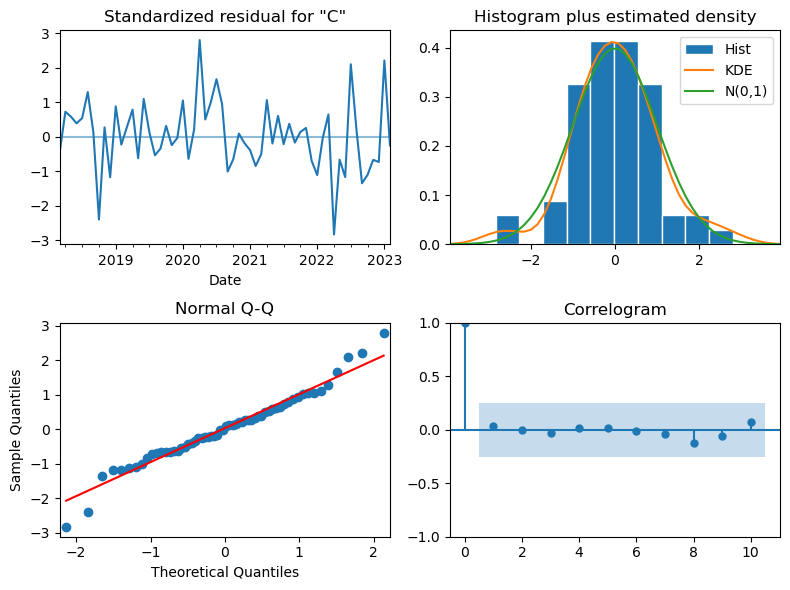

In [61]:
#Diagnostic Plots
results.plot_diagnostics(figsize=(8,6))
plt.tight_layout()
plt.show()

In [62]:
# Compute In-Sample Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Get in-sample predictions (log scale)
predictions = results.get_prediction(start=log_close.index[0], dynamic=False)
predicted_log = predictions.predicted_mean

# Convert to original scale and align with actual prices
predicted_prices = np.exp(predicted_log)
actual_prices = monthly_close.loc[predicted_log.index]

# Calculate metrics
mae = mean_absolute_error(actual_prices, predicted_prices)
mse = mean_squared_error(actual_prices, predicted_prices)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((actual_prices - predicted_prices) / actual_prices)) * 100

print("\nModel Evaluation Metrics:")
print(f"MAE: ${mae:.2f}")
print(f"MSE: ${mse:.2f}")
print(f"RMSE: ${rmse:.2f}")
print(f"MAPE: {mape:.2f}%")


Model Evaluation Metrics:
MAE: $9.46
MSE: $215.43
RMSE: $14.68
MAPE: 8.59%


# Forecast the Next 24 Months(2 years)

In [63]:
# Generate forecasts for the next 24 months (in log scale)
# Convert the forecast mean and confidence interval to original scale

def forecast_and_convert(model_results, steps):
    """
    Generate forecasts for a given number of steps ahead using a fitted ARIMA model,
    and convert results from log scale to original scale.
    
    Parameters:
    model_results (ARIMAResults): The fitted ARIMA model from which to forecast.
    steps (int): Number of future steps to forecast.
    
    Returns:
    tuple: Tuple containing the forecasted mean values and confidence intervals in both scales.
    """
    # Generate forecasts in log scale
    forecast_log = model_results.get_forecast(steps=steps)
    log_forecast_mean = forecast_log.predicted_mean  # predicted log values
    log_conf_int = forecast_log.conf_int()           # confidence intervals in log scale

    # Convert the forecast and confidence intervals to original scale
    forecast_mean = np.exp(log_forecast_mean)  # Convert mean to original scale
    conf_lower = np.exp(log_conf_int.iloc[:, 0])  # Convert lower bound
    conf_upper = np.exp(log_conf_int.iloc[:, 1])  # Convert upper bound

    # Optionally, print the first few values to check
    print("First 5 forecasted log values:")
    print(log_forecast_mean[:5])
    print("First 5 forecasted original scale values:")
    print(forecast_mean[:5])

    return (log_forecast_mean, log_conf_int, forecast_mean, conf_lower, conf_upper)


log_forecast_mean, log_conf_int, forecast_mean, conf_lower, conf_upper = forecast_and_convert(results, 24)


First 5 forecasted log values:
2023-03-31    4.654189
2023-04-30    4.586830
2023-05-31    4.579627
2023-06-30    4.563974
2023-07-31    4.549404
Freq: M, Name: predicted_mean, dtype: float64
First 5 forecasted original scale values:
2023-03-31    105.023993
2023-04-30     98.182653
2023-05-31     97.478016
2023-06-30     95.964076
2023-07-31     94.576039
Freq: M, Name: predicted_mean, dtype: float64


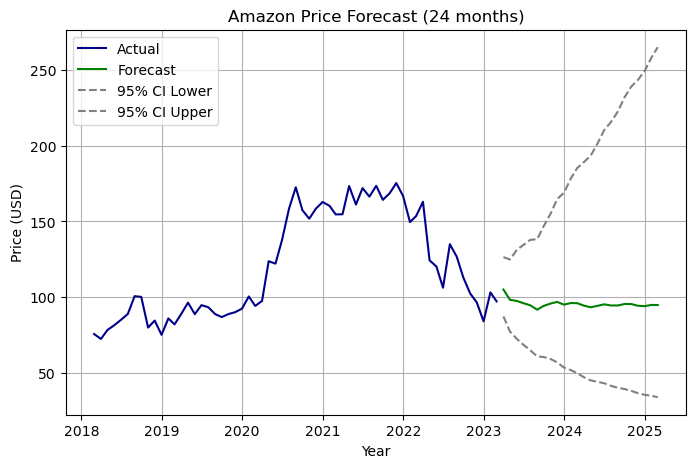

In [64]:
#plot actual vs forecast with intervals
plt.figure(figsize=(8,5))
plt.plot(monthly_close.index, monthly_close.values, label='Actual', color='darkblue')
plt.plot(forecast_mean.index, forecast_mean.values, label='Forecast', color='green')
plt.plot(forecast_mean.index, conf_lower, color='gray', linestyle='--', label='95% CI Lower')
plt.plot(forecast_mean.index, conf_upper, color='gray', linestyle='--', label='95% CI Upper')
plt.title('Amazon Price Forecast (24 months)')
plt.xlabel('Year'); plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

# LSTM and GRU Model Case Study on Amazon Data Time Series Forecasting

LSTM Metrics: {'MAE': 177.38454457674712, 'MSE': 53883.96095997165, 'RMSE': 232.12919023675514, 'MAPE': 157.63938102532282}
GRU Metrics: {'MAE': 130.51807367845333, 'MSE': 28352.094120097598, 'RMSE': 168.38080092486078, 'MAPE': 116.67265766889503}


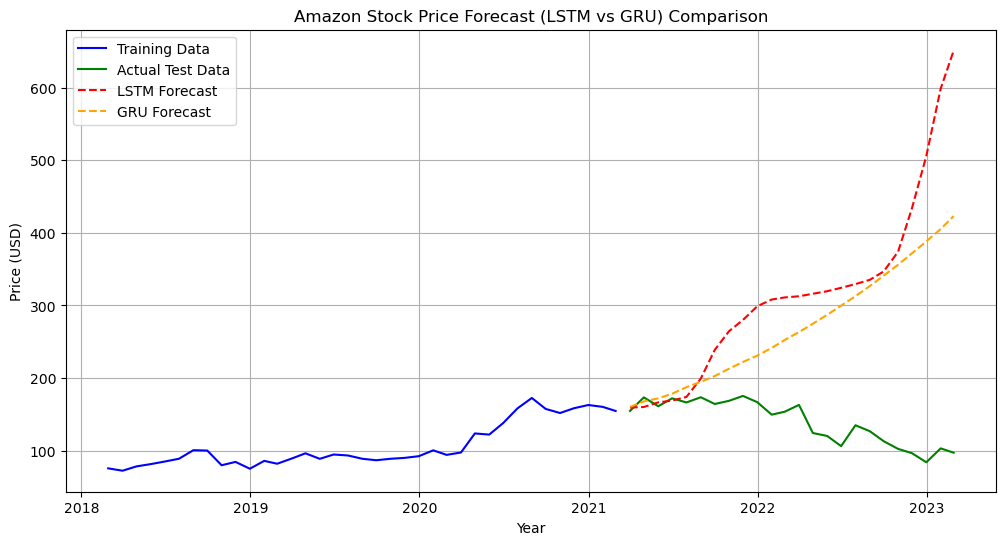

In [65]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense
import tensorflow as tf

def load_and_preprocess_data(filepath, test_size=24):
    """Load and preprocess time series data"""
    df = pd.read_csv(filepath, parse_dates=['Date'])
    df.set_index('Date', inplace=True)
    
    # Resample to monthly frequency
    monthly_series = df['Close'].resample('M').last()
    
    # Train-test split
    train_series = monthly_series.iloc[:-test_size]
    test_series = monthly_series.iloc[-test_size:]
    
    return train_series, test_series, monthly_series

def make_stationary_series(series):
    """Apply log transformation and differencing"""
    log_series = np.log(series)
    diff_series = log_series.diff().dropna()
    return log_series, diff_series

def create_sequences(data, window_size):
    """Create input-output sequences for time series modeling"""
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i])
        y.append(data[i])
    return np.array(X), np.array(y)

def build_model(model_type='lstm', window_size=12, units=50, activation='relu'):
    """Build LSTM/GRU model architecture"""
    model = Sequential()
    if model_type.lower() == 'lstm':
        model.add(LSTM(units, activation=activation, input_shape=(window_size, 1)))
    elif model_type.lower() == 'gru':
        model.add(GRU(units, activation=activation, input_shape=(window_size, 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

def forecast_future_prices(model, last_window, last_log_value, scaler, steps=24, window_size=12):
    """Generate recursive forecasts using trained model"""
    predictions = []
    current_window = last_window.copy()
    current_log = last_log_value
    
    for _ in range(steps):
        # Scale and reshape input
        scaled_window = scaler.transform(current_window.reshape(-1, 1))
        input_seq = scaled_window.reshape(1, window_size, 1)
        
        # Predict next difference
        pred_diff_scaled = model.predict(input_seq, verbose=0)
        pred_diff = scaler.inverse_transform(pred_diff_scaled)[0, 0]
        
        # Update log price and window
        current_log += pred_diff
        predictions.append(np.exp(current_log))
        current_window = np.append(current_window[1:], [pred_diff])
    
    return np.array(predictions)

def evaluate_forecasts(actual, predictions):
    """Calculate evaluation metrics"""
    metrics = {
        'MAE': mean_absolute_error(actual, predictions),
        'MSE': mean_squared_error(actual, predictions),
        'RMSE': np.sqrt(mean_squared_error(actual, predictions)),
        'MAPE': np.mean(np.abs((actual - predictions) / actual)) * 100
    }
    return metrics

def plot_results(train_series, test_series, forecasts, model_names):
    """Visualize actual vs predicted values"""
    plt.figure(figsize=(12, 6))
    plt.plot(train_series.index, train_series, label='Training Data', color='blue')
    plt.plot(test_series.index, test_series, label='Actual Test Data', color='green')
    
    colors = ['red', 'orange', 'purple']
    for i, (name, values) in enumerate(zip(model_names, forecasts)):
        plt.plot(test_series.index, values, label=f'{name} Forecast', 
                color=colors[i], linestyle='--')
    
    plt.title('Amazon Stock Price Forecast (LSTM vs GRU) Comparison')
    plt.xlabel('Year')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Main Execution Flow
if __name__ == "__main__":
    # Configuration
    FILE_PATH = "AMZN.csv"
    WINDOW_SIZE = 12
    EPOCHS = 100
    TEST_SIZE = 24
    
    # Set random seeds
    np.random.seed(42)
    tf.random.set_seed(42)
    
    # Load and preprocess data
    train_series, test_series, full_series = load_and_preprocess_data(FILE_PATH, TEST_SIZE)
    
    # Make series stationary
    log_series, diff_series = make_stationary_series(full_series)
    train_diff = diff_series[:train_series.index.max()]
    
    # Create sequences
    X, y = create_sequences(train_diff.values, WINDOW_SIZE)
    
    # Scale data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X.reshape(-1, 1)).reshape(X.shape)
    y_scaled = scaler.transform(y.reshape(-1, 1)).flatten()
    X_scaled = X_scaled.reshape((X_scaled.shape[0], WINDOW_SIZE, 1))
    
    # Build and train models
    lstm_model = build_model('lstm', WINDOW_SIZE)
    gru_model = build_model('gru', WINDOW_SIZE)
    
    lstm_history = lstm_model.fit(X_scaled, y_scaled, epochs=EPOCHS, verbose=0)
    gru_history = gru_model.fit(X_scaled, y_scaled, epochs=EPOCHS, verbose=0)
    
    # Generate forecasts
    last_window = train_diff[-WINDOW_SIZE:].values
    last_log = log_series[train_series.index.max()]
    
    lstm_forecast = forecast_future_prices(lstm_model, last_window, last_log, scaler, TEST_SIZE, WINDOW_SIZE)
    gru_forecast = forecast_future_prices(gru_model, last_window, last_log, scaler, TEST_SIZE, WINDOW_SIZE)
    
    # Evaluate performance
    lstm_metrics = evaluate_forecasts(test_series.values, lstm_forecast)
    gru_metrics = evaluate_forecasts(test_series.values, gru_forecast)
    
    print("LSTM Metrics:", lstm_metrics)
    print("GRU Metrics:", gru_metrics)
    
    # Visualize results
    plot_results(train_series, test_series, [lstm_forecast, gru_forecast], ['LSTM', 'GRU'])